# Perform Textual Embedding

## Loading Credentials

In [1]:
import json
import os
import pandas as pd

data_path = '../Mikey_data/'
if os.path.exists(data_path):
    os.chdir(data_path)
    print('Changed directory to data path:', os.getcwd())
else:
    print('Data path does not exist:', data_path)

with open('credentials.json', 'r') as file:
    credentials = json.load(file)

db_server_name = credentials['clickhouse']['server_name']
db_username = credentials['clickhouse']['username']
db_password = credentials['clickhouse']['password']

Changed directory to data path: /home/mfin7037_best_students/code/Mikey_data


## Test Connection

In [2]:
from clickhouse_driver import Client

client = Client(host=db_server_name, user=db_username, password=db_password)

try:
    result = client.execute('SELECT version()')
    print("Connected to ClickHouse server. Version:", result[0][0])
except Exception as e:
    print("Failed to connect to ClickHouse server:", e)

Connected to ClickHouse server. Version: 25.4.1.1926


In [3]:
client.execute('describe tiingo.news')

[('crawlDate', 'Nullable(String)', '', '', '', '', ''),
 ('description', 'Nullable(String)', '', '', '', '', ''),
 ('id', 'Nullable(Float64)', '', '', '', '', ''),
 ('publishedDate', 'Nullable(String)', '', '', '', '', ''),
 ('source', 'Nullable(String)', '', '', '', '', ''),
 ('tags', 'Nullable(String)', '', '', '', '', ''),
 ('ticker', 'Nullable(String)', '', '', '', '', ''),
 ('tickers_all', 'Nullable(String)', '', '', '', '', ''),
 ('title', 'Nullable(String)', '', '', '', '', ''),
 ('tld', 'Nullable(String)', '', '', '', '', ''),
 ('url', 'Nullable(String)', '', '', '', '', '')]

## Filter Tiingo Data

In [4]:
import pandas as pd
from clickhouse_driver import Client

client = Client(host=db_server_name, user=db_username, password=db_password)

# query btc news
query = f"""
SELECT  distinct(id) as id,
        description,
        ticker,
        tickers_all,
        title,
        parseDateTimeBestEffort(publishedDate) AS date 
FROM tiingo.news
WHERE ticker in ('btc', 'eth', 'doge', 'sol')
AND date >= '2016-01-01'
AND LENGTH(description) <= 8192
"""

# fetch the result directly as a pandas DataFrame directly
news_data_df = client.query_dataframe(query)

In [5]:
news_data_df

,id,description,ticker,tickers_all,title,date
0,46018628.0,"Bitcoin (CRYPTO: BTC), the world’s oldest cryp...",btc,btc/ko/mcd,"Bitcoin Drops Further To This Level, Here Are ...",2022-07-26 08:25:11
1,22921263.0,Ethan Allen Interiors (NYSE:ETH) is scheduled ...,eth,eth,Ethan Allen Interiors Q2 2020 Earnings Preview,2020-02-04 06:35:00
2,22910463.0,"Today, we'll introduce the concept of the P/E ...",eth,eth,Is Ethan Allen Interiors Inc.’s (NYSE:ETH) Hig...,2020-02-03 20:36:59
3,22902421.0,Ethan Allen Interiors (NYSE:ETH) will issue it...,eth,eth,Ethan Allen Interiors (ETH) Set to Announce Qu...,2020-02-03 16:24:00
4,14140567.0,Siacoin (CURRENCY:SC) traded down 3.5% against...,btc,bch/btc/btg/ltc,Siacoin (CRYPTO:SC) 1-Day Trading Volume Hits ...,2018-12-03 22:31:34
...,...,...,...,...,...,...
23224,11401988.0,SOILcoin (CURRENCY:SOIL) traded 1.4% higher ag...,btc,bch/btc/btg/ltc/soil,SOILcoin (SOIL) Price Hits $0.0195 on Exchanges,2018-06-10 06:35:14
23225,11401994.0,Bitcoin Cash (CURRENCY:BCH) traded 1.4% lower ...,btc,atb/bch/btc/trc/uno,Bitcoin Cash Price Up 2.4% Over Last Week (BCH),2018-06-10 06:35:26
23226,41887075.0,ReneSola (NYSE:SOL – Get Rating) was downgrade...,sol,db/gs/gsf/gsj/sol/sol,Zacks Investment Research Lowers ReneSola (NYS...,2022-02-24 00:15:57
23227,22536649.0,Ethan Allen Interiors Inc. (NYSE:ETH) – Analys...,eth,eth/key,Ethan Allen Interiors Inc. (NYSE:ETH) to Post ...,2020-01-16 15:02:42


## LLM Embeddings
- Mistral AI: https://docs.mistral.ai/capabilities/embeddings/
- sentence-transformers: all-MiniLM-L6-v2
    - Lightweight (23M parameters) with 384-dimensional embeddings.
    - Fine-tuned for semantic tasks (clustering, similarity search).
    - Automatically applies mean pooling during inference.

### Example

In [16]:
from mistralai import Mistral

api_key = credentials['api_key']['mistral']
mistral_client = Mistral(api_key=api_key)

model = "mistral-embed"
text = "Embed this sentence."

embeddings_batch_response= mistral_client.embeddings.create(
    model=model,
    inputs=text,
)

print(embeddings_batch_response.data[0].embedding)
print('length of embedding:', len(embeddings_batch_response.data[0].embedding))

[-0.01666259765625, 0.06982421875, 0.031494140625, 0.01284027099609375, 0.020660400390625, 0.0096435546875, 0.025787353515625, 0.0018548965454101562, -0.00867462158203125, -0.0087890625, -0.039703369140625, 0.058441162109375, -0.0255584716796875, 0.00775909423828125, -0.02886962890625, 0.0404052734375, 0.05499267578125, 0.0260162353515625, 0.03173828125, 0.023284912109375, -0.05682373046875, -0.0157470703125, -0.061614990234375, 0.01226806640625, -0.046112060546875, -0.0270538330078125, -0.00775909423828125, -0.03790283203125, -0.0401611328125, 0.0010061264038085938, 0.0238494873046875, -0.030120849609375, 0.0303497314453125, -0.002353668212890625, -0.0120391845703125, -0.036285400390625, -0.0330810546875, -0.044952392578125, 0.0133514404296875, 0.00186920166015625, 0.00969696044921875, -0.00034046173095703125, -0.0308074951171875, -0.0230560302734375, -0.024871826171875, -0.0296783447265625, 0.00447845458984375, -0.0279541015625, -0.0176849365234375, -0.0330810546875, 0.00987243652343

### Run Embeddings

In [6]:
from mistralai import Mistral
import time
from tqdm import tqdm

def run_mistral_embedding(df: pd.DataFrame, api_key, model: str = 'mistral-embed', batch_size: int = 10) -> None:
    mistral_client = Mistral(api_key=api_key)

    # Initialize new column
    df['mistral_embedding'] = None

    # Process in batches
    for start_idx in tqdm(range(0, len(df), batch_size)):
        end_idx = min(start_idx + batch_size, len(df))
        batch_texts = df.loc[start_idx:end_idx - 1, 'description'].tolist()

        embeddings_batch_response = mistral_client.embeddings.create(
            model=model,
            inputs=batch_texts,
        )

        # Write result embeddings values to df
        for i, embedding in enumerate(embeddings_batch_response.data):
            df.loc[start_idx + i, 'mistral_embedding'] = str(embedding.embedding)

        # request rate is limited, mistral is annoying
        time.sleep(2)

In [7]:
import pandas as pd
import requests

def run_miniLM_embedding(df: pd.DataFrame, api_token: str, batch_size=10, max_retries=3) -> None:
    """
    Process text embeddings in batches using the sentence-transformers/all-MiniLM-L6-v2 model.
    
    Args:
        df: pandas DataFrame containing the text data
        api_token: Hugging Face API token
        batch_size: number of texts to process in each batch
        max_retries: maximum number of retry attempts per batch
    """

    model_id = "sentence-transformers/all-MiniLM-L6-v2"
    api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{model_id}"
    headers = {"Authorization": f"Bearer {api_token}"}

    # Initialize new column
    df['embeddings'] = None

    # Process in batches
    for start_idx in tqdm(range(0, len(df), batch_size)):
        end_idx = min(start_idx + batch_size, len(df))
        batch_texts = df.loc[start_idx:end_idx - 1, 'description'].tolist()

        # Try to get embeddings with retries
        for attempt in range(max_retries):
            response = requests.post(
                api_url, 
                headers=headers, 
                json={
                    "inputs": batch_texts,
                    "options": {
                        "wait_for_model": True,
                        "use_cache": False 
                    }
                }
            )
            
            if response.status_code == 200:
                embeddings = response.json()
                # Store embeddings in DataFrame
                for i, embedding in enumerate(embeddings):
                    df.loc[start_idx + i, 'embeddings'] = str(embedding)
            elif response.status_code == 503 and attempt < max_retries - 1:
                # Model loading - wait with exponential backoff
                wait_time = 2 ** attempt
                print(f"Model loading, retrying in {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"Embedding failed for batch {start_idx}-{end_idx}: {response.text}")
                continue

In [12]:
api_key = credentials['api_key']['mistral']
test_df = news_data_df.iloc[:20, :]
run_mistral_embedding(test_df, api_key=api_key, model='mistral-embed')

/tmp/ipykernel_942756/2195579779.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mistral_embedding'] = None
100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


In [8]:
test_df = news_data_df.iloc[:50, :]
run_miniLM_embedding(test_df, credentials['api_key']['huggingface'], batch_size=5)

/tmp/ipykernel_960091/1363628125.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embeddings'] = None
100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


In [9]:
test_df

,id,description,ticker,tickers_all,title,date,embeddings
0,46018628.0,"Bitcoin (CRYPTO: BTC), the world’s oldest cryp...",btc,btc/ko/mcd,"Bitcoin Drops Further To This Level, Here Are ...",2022-07-26 08:25:11,"[0.00932822935283184, 0.051099956035614014, -0..."
1,22921263.0,Ethan Allen Interiors (NYSE:ETH) is scheduled ...,eth,eth,Ethan Allen Interiors Q2 2020 Earnings Preview,2020-02-04 06:35:00,"[2.5673110940260813e-05, 0.022189155220985413,..."
2,22910463.0,"Today, we'll introduce the concept of the P/E ...",eth,eth,Is Ethan Allen Interiors Inc.’s (NYSE:ETH) Hig...,2020-02-03 20:36:59,"[0.04613637179136276, -0.0028543814551085234, ..."
3,22902421.0,Ethan Allen Interiors (NYSE:ETH) will issue it...,eth,eth,Ethan Allen Interiors (ETH) Set to Announce Qu...,2020-02-03 16:24:00,"[0.03992808982729912, 0.011753503233194351, 0...."
4,14140567.0,Siacoin (CURRENCY:SC) traded down 3.5% against...,btc,bch/btc/btg/ltc,Siacoin (CRYPTO:SC) 1-Day Trading Volume Hits ...,2018-12-03 22:31:34,"[0.013980322517454624, 0.019896769896149635, -..."
5,14141938.0,CHIPS (CURRENCY:CHIPS) traded flat against the...,btc,atb/bch/btc/trc/unb/uno,CHIPS Price Up 91.5% Over Last 7 Days (CRYPTO:...,2018-12-03 23:07:39,"[-0.015249173156917095, 0.011437520384788513, ..."
6,11787584.0,Unitus (CURRENCY:UIS) traded 1.4% lower agains...,btc,bch/btc/btg/ltc/uis,Unitus Price Reaches $0.0130 on Major Exchange...,2018-06-27 22:28:22,"[-0.03640827536582947, -0.04086567461490631, -..."
7,40831812.0,"NEW YORK, Jan. 16, 2022 (GLOBE NEWSWIRE) -- ...",sol,prpl/rol/sli/sli/sol/sol,"Bragar Eagel & Squire, P.C. Is Investigating R...",2022-01-17 10:00:00,"[-0.09586366266012192, -0.016025058925151825, ..."
8,10394577.0,Dynamic (CURRENCY:DYN) traded 1.7% higher agai...,btc,bch/btc/btg/dyn/ltc,Dynamic Trading Down 5.4% This Week (DYN),2018-04-29 00:04:41,"[-0.020419128239154816, -0.011399632319808006,..."
9,5190146.0,Equities analysts forecast that Ethan Allen In...,eth,eth,$0.27 Earnings Per Share Expected for Ethan Al...,2017-04-15 03:18:02,"[0.040532004088163376, 0.011114508844912052, 0..."


## Analysis

### Data Prep

In [10]:
import os
import pandas as pd

data_path = '../Mikey_data/'
if os.path.exists(data_path):
    os.chdir(data_path)
    print('Changed directory to data path:', os.getcwd())
else:
    print('Data path does not exist:', data_path)

Changed directory to data path: /home/mfin7037_best_students/code/Mikey_data


In [11]:
import pandas as pd
from clickhouse_driver import Client
import gc
import json

# load calculated embedding values from a saved file
mistral_embed_df = pd.read_parquet('mistral_embeddings.parquet')

# query news data
client = Client(host=db_server_name, user=db_username, password=db_password)

query = f"""
SELECT  distinct(id) as id,
        description,
        ticker,
        tickers_all,
        title,
        parseDateTimeBestEffort(publishedDate) AS date 
FROM tiingo.news
WHERE ticker in ('btc', 'eth', 'doge', 'sol')
AND LENGTH(description) <= 8192
"""

# fetch the result directly as a pandas DataFrame directly
news_data_df = client.query_dataframe(query)

# Merge the two DataFrames on the 'id' column
news_mistral_embed_df = pd.merge(news_data_df, mistral_embed_df, on='id', how='left')

# release memory
del mistral_embed_df
del news_data_df
gc.collect()

news_mistral_embed_df

,id,description,ticker,tickers_all,title,date,mistral_embedding
0,34085277.0,"Bitcoin regains $50,000 heading into the end o...",btc,btc/btc,5 things to watch in Bitcoin this week as gree...,2021-04-26 17:04:23,"[-0.00873565673828125, 0.0687255859375, 0.0361..."
1,17663467.0,Here are four stocks with buy rank and strong ...,eth,eth/gis/lvs/mpx,Top Ranked Income Stocks to Buy for June 10th,2019-06-10 23:15:00,"[-0.020111083984375, 0.0308685302734375, 0.013..."
2,31605587.0,Bitcoin has been legitimized by Interest from ...,btc,amjl/btc/cs/db/dtk/jpm/jpm-ws/mstr/pypl/pyplv,3 reasons why bitcoin has doubled in less than...,2021-01-09 21:15:00,"[-0.0160980224609375, 0.02362060546875, 0.0343..."
3,10608904.0,Aidos Kuneen (CURRENCY:ADK) traded 4.1% higher...,btc,adk/bch/btc/btg/ltc/nano,Aidos Kuneen Tops 24-Hour Trading Volume of $5...,2018-05-08 11:58:53,"[-0.01113128662109375, 0.027618408203125, 0.06..."
4,10609714.0,PRIZM (CURRENCY:PZM) traded down 4.7% against ...,btc,bch/btc/emc/ppc,PRIZM Trading 5.6% Lower Over Last Week (PZM),2018-05-08 12:52:38,"[-0.032806396484375, 0.01532745361328125, 0.04..."
...,...,...,...,...,...,...,...
23878,29067605.0,Cryptocurrencies continue correcting not far f...,btc,btc/ltc/trx,"Crypto Price Analysis September 23: BTC, ETH, ...",2020-09-24 01:06:18,"[-0.0035305023193359375, 0.046173095703125, 0...."
23879,29067764.0,In order not to fall for scammers you should c...,btc,btc,5 Ways to Protect Your Crypto Accounts From Fraud,2020-09-24 03:33:31,"[0.005771636962890625, 0.00717926025390625, 0...."
23880,12501204.0,NIX (CURRENCY:NIX) traded 3.3% lower against t...,btc,bch/btc/btg/ltc,NIX Trading 10.1% Higher Over Last Week (NIX),2018-08-19 20:04:54,"[-0.007579803466796875, 0.035614013671875, 0.0..."
23881,12502799.0,MassGrid (CURRENCY:MGD) traded up 1.4% against...,btc,bch/btc/btg/ltc,MassGrid Price Hits $0.0850 (MGD),2018-08-20 01:54:41,"[0.0155181884765625, -0.012176513671875, 0.039..."


In [12]:
import duckdb
# some data filtering, let's focus on btc first
# 1. ticker = btc
# 2. after 2016-01-01
# 3. description is not empty

filter_df = duckdb.query(
    """
    SELECT *
    FROM news_mistral_embed_df
    WHERE ticker = 'btc'
    AND date >= '2016-01-01'
    AND description != ''
    AND description != ' '
    """
).fetchdf()

filter_df

,id,description,ticker,tickers_all,title,date,mistral_embedding
0,34085277.0,"Bitcoin regains $50,000 heading into the end o...",btc,btc/btc,5 things to watch in Bitcoin this week as gree...,2021-04-26 17:04:23,"[-0.00873565673828125, 0.0687255859375, 0.0361..."
1,31605587.0,Bitcoin has been legitimized by Interest from ...,btc,amjl/btc/cs/db/dtk/jpm/jpm-ws/mstr/pypl/pyplv,3 reasons why bitcoin has doubled in less than...,2021-01-09 21:15:00,"[-0.0160980224609375, 0.02362060546875, 0.0343..."
2,10608904.0,Aidos Kuneen (CURRENCY:ADK) traded 4.1% higher...,btc,adk/bch/btc/btg/ltc/nano,Aidos Kuneen Tops 24-Hour Trading Volume of $5...,2018-05-08 11:58:53,"[-0.01113128662109375, 0.027618408203125, 0.06..."
3,10609714.0,PRIZM (CURRENCY:PZM) traded down 4.7% against ...,btc,bch/btc/emc/ppc,PRIZM Trading 5.6% Lower Over Last Week (PZM),2018-05-08 12:52:38,"[-0.032806396484375, 0.01532745361328125, 0.04..."
4,45925924.0,Electric vehicle leader Tesla Inc (NASDAQ: TSL...,btc,barl/btc/ms/msk/mwg/mwo/mwr/pifi/tsla/wfc/wfc-ws,"Tesla Bitcoin Sale A Positive, But Can The Com...",2022-07-21 20:19:55,"[-0.0212249755859375, 0.052947998046875, 0.033..."
...,...,...,...,...,...,...,...
17273,29067605.0,Cryptocurrencies continue correcting not far f...,btc,btc/ltc/trx,"Crypto Price Analysis September 23: BTC, ETH, ...",2020-09-24 01:06:18,"[-0.0035305023193359375, 0.046173095703125, 0...."
17274,29067764.0,In order not to fall for scammers you should c...,btc,btc,5 Ways to Protect Your Crypto Accounts From Fraud,2020-09-24 03:33:31,"[0.005771636962890625, 0.00717926025390625, 0...."
17275,12501204.0,NIX (CURRENCY:NIX) traded 3.3% lower against t...,btc,bch/btc/btg/ltc,NIX Trading 10.1% Higher Over Last Week (NIX),2018-08-19 20:04:54,"[-0.007579803466796875, 0.035614013671875, 0.0..."
17276,12502799.0,MassGrid (CURRENCY:MGD) traded up 1.4% against...,btc,bch/btc/btg/ltc,MassGrid Price Hits $0.0850 (MGD),2018-08-20 01:54:41,"[0.0155181884765625, -0.012176513671875, 0.039..."


In [13]:
btc_daily = pd.read_pickle('btc_daily.pkl')
btc_daily.reset_index(inplace=True)

# some processing
btc_daily.rename(columns={'Open time': 'date'}, inplace=True)
btc_daily.sort_values(by='date', inplace=True)
btc_daily['return'] = btc_daily['Close'].pct_change()
btc_daily

,date,Open,High,Low,Close,Volume,Close time,Quote volume,Trades,Taker buy base,Taker buy quote,Ignore,return
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17 23:59:59.999,3.454770e+06,3427,616.24854100,2678216.40060401,0,NaN
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18 23:59:59.999,5.086958e+06,5233,972.86871000,4129123.31651808,0,-0.041238
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19 23:59:59.999,1.549484e+06,2153,274.33604200,1118001.87008735,0,0.007694
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20 23:59:59.999,1.930364e+06,2321,376.79594700,1557401.33373730,0,-0.012969
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21 23:59:59.999,2.797232e+06,3972,557.35610700,2255662.55315837,0,-0.017201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2753,2025-03-01,84349.95,86558.00,83824.78,86064.53,25785.054640,2025-03-01 23:59:59.999,2.194004e+09,3700728,11748.10769000,1000093822.53835250,0,0.020327
2754,2025-03-02,86064.54,95000.00,85050.60,94270.00,54889.090450,2025-03-02 23:59:59.999,4.972550e+09,7403218,29273.81031000,2652973441.15453900,0,0.095341
2755,2025-03-03,94269.99,94416.46,85117.11,86220.61,59171.102180,2025-03-03 23:59:59.999,5.321124e+09,9797860,27915.43650000,2513464571.35691100,0,-0.085387
2756,2025-03-04,86221.16,88967.52,81500.00,87281.98,55609.107060,2025-03-04 23:59:59.999,4.704901e+09,10326631,27584.71590000,2335087296.23928690,0,0.012310


In [14]:
# normalise date before merging
filter_df['date'] = filter_df['date'].dt.normalize()
btc_daily['date'] = btc_daily['date'].dt.normalize()

mistal_embedding_btc_df = pd.merge(
    filter_df,
    btc_daily,
    on='date',
    how='inner'
)

mistal_embedding_btc_df

,id,description,ticker,tickers_all,title,date,mistral_embedding,Open,High,Low,Close,Volume,Close time,Quote volume,Trades,Taker buy base,Taker buy quote,Ignore,return
0,34085277.0,"Bitcoin regains $50,000 heading into the end o...",btc,btc/btc,5 things to watch in Bitcoin this week as gree...,2021-04-26,"[-0.00873565673828125, 0.0687255859375, 0.0361...",49066.76,54356.62,48753.44,54001.39,86310.802124,2021-04-26 23:59:59.999,4.555689e+09,2174544,43183.93674900,2277375506.85531338,0,0.100569
1,31605587.0,Bitcoin has been legitimized by Interest from ...,btc,amjl/btc/cs/db/dtk/jpm/jpm-ws/mstr/pypl/pyplv,3 reasons why bitcoin has doubled in less than...,2021-01-09,"[-0.0160980224609375, 0.02362060546875, 0.0343...",40586.96,41380.00,38720.00,40088.22,75785.979675,2021-01-09 23:59:59.999,3.054779e+09,1998156,37007.32190900,1491990705.55169908,0,-0.012187
2,10608904.0,Aidos Kuneen (CURRENCY:ADK) traded 4.1% higher...,btc,adk/bch/btc/btg/ltc/nano,Aidos Kuneen Tops 24-Hour Trading Volume of $5...,2018-05-08,"[-0.01113128662109375, 0.027618408203125, 0.06...",9365.00,9475.70,9060.54,9187.56,25533.831889,2018-05-08 23:59:59.999,2.364182e+08,189159,13086.54746700,121220083.42296955,0,-0.018947
3,10609714.0,PRIZM (CURRENCY:PZM) traded down 4.7% against ...,btc,bch/btc/emc/ppc,PRIZM Trading 5.6% Lower Over Last Week (PZM),2018-05-08,"[-0.032806396484375, 0.01532745361328125, 0.04...",9365.00,9475.70,9060.54,9187.56,25533.831889,2018-05-08 23:59:59.999,2.364182e+08,189159,13086.54746700,121220083.42296955,0,-0.018947
4,45925924.0,Electric vehicle leader Tesla Inc (NASDAQ: TSL...,btc,barl/btc/ms/msk/mwg/mwo/mwr/pifi/tsla/wfc/wfc-ws,"Tesla Bitcoin Sale A Positive, But Can The Com...",2022-07-21,"[-0.0212249755859375, 0.052947998046875, 0.033...",23223.30,23442.77,22341.46,23152.19,184817.681910,2022-07-21 23:59:59.999,4.232412e+09,4808194,92958.79400000,2128895623.65998300,0,-0.003062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17273,29067605.0,Cryptocurrencies continue correcting not far f...,btc,btc/ltc/trx,"Crypto Price Analysis September 23: BTC, ETH, ...",2020-09-24,"[-0.0035305023193359375, 0.046173095703125, 0....",10241.46,10795.24,10190.93,10736.32,57676.619427,2020-09-24 23:59:59.999,6.045209e+08,789282,27946.80432500,292936072.98704616,0,0.048319
17274,29067764.0,In order not to fall for scammers you should c...,btc,btc,5 Ways to Protect Your Crypto Accounts From Fraud,2020-09-24,"[0.005771636962890625, 0.00717926025390625, 0....",10241.46,10795.24,10190.93,10736.32,57676.619427,2020-09-24 23:59:59.999,6.045209e+08,789282,27946.80432500,292936072.98704616,0,0.048319
17275,12501204.0,NIX (CURRENCY:NIX) traded 3.3% lower against t...,btc,bch/btc/btg/ltc,NIX Trading 10.1% Higher Over Last Week (NIX),2018-08-19,"[-0.007579803466796875, 0.035614013671875, 0.0...",6387.96,6541.00,6300.00,6477.53,45190.847994,2018-08-19 23:59:59.999,2.892720e+08,190758,25368.61327200,162405728.97807813,0,0.014022
17276,12502799.0,MassGrid (CURRENCY:MGD) traded up 1.4% against...,btc,bch/btc/btg/ltc,MassGrid Price Hits $0.0850 (MGD),2018-08-20,"[0.0155181884765625, -0.012176513671875, 0.039...",6477.53,6530.00,6220.00,6254.84,49435.555260,2018-08-20 23:59:59.999,3.176179e+08,237055,26468.01709100,170185693.09984116,0,-0.034379


In [15]:
import numpy as np

daily_embed_df = (
    mistal_embedding_btc_df
    .groupby('date')
    .apply(
        lambda g: pd.Series(
            {
                # because group, pick last row return
                'return': g['return'].iloc[-1],
                
                # take the average of each positions (index) of embeddings, each day
                'embedding': np.mean(np.stack(g['mistral_embedding'].values), axis=0) 
            }
        )
    )
).reset_index()

# lag embedding
daily_embed_df['embedding_lag'] = daily_embed_df['embedding'].shift(1)
daily_embed_df = daily_embed_df.drop(index=0, columns='embedding').reset_index(drop=True)

/tmp/ipykernel_862491/390078815.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [16]:
# expand the 'embedding' column into separate columns
expanded_df = pd.DataFrame(
    daily_embed_df['embedding_lag'].tolist(), 
    columns=[f'embedding_{i}_lag' for i in range(len(daily_embed_df['embedding_lag'][0]))]
)

daily_embed_df = pd.concat([daily_embed_df.drop(columns=['embedding_lag']), expanded_df], axis=1)

daily_embed_df

,date,return,embedding_0_lag,embedding_1_lag,embedding_2_lag,embedding_3_lag,embedding_4_lag,embedding_5_lag,embedding_6_lag,embedding_7_lag,...,embedding_1014_lag,embedding_1015_lag,embedding_1016_lag,embedding_1017_lag,embedding_1018_lag,embedding_1019_lag,embedding_1020_lag,embedding_1021_lag,embedding_1022_lag,embedding_1023_lag
0,2017-12-06,0.158125,-0.014000,0.035645,0.026917,-0.029190,0.057434,0.023087,0.020462,-0.018906,...,-0.056458,-0.010704,0.022369,0.018906,-0.012146,0.004307,-0.019501,-0.024292,-0.017105,0.001959
1,2017-12-07,0.225014,-0.007773,0.038190,0.025751,-0.007216,0.035756,0.020763,0.015670,-0.025264,...,-0.018067,0.025317,0.004465,0.020389,-0.002879,0.017883,-0.003815,-0.002388,0.015752,-0.008080
2,2017-12-08,-0.043316,-0.016308,0.017751,0.010625,-0.030314,0.021932,0.027454,0.031698,-0.031474,...,-0.025777,0.025899,0.002792,0.021601,-0.017404,0.026360,0.009908,0.002462,0.022797,-0.008427
3,2017-12-09,-0.077074,-0.013145,0.055725,0.053925,-0.015823,-0.004486,0.057495,0.041229,-0.034973,...,-0.023285,0.031433,0.016937,0.015266,-0.016266,0.024063,-0.007465,-0.001560,0.020828,-0.010864
4,2017-12-11,0.113288,-0.003265,0.032379,0.010201,-0.018110,0.036469,0.027298,0.034554,-0.015747,...,-0.013737,0.026588,0.013645,0.030670,-0.007328,0.006615,0.001179,-0.015428,0.020081,-0.008551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,2022-09-04,0.008491,-0.018079,0.027744,0.029799,-0.003528,0.030145,0.025587,0.016726,-0.021141,...,-0.024320,0.001675,0.027020,0.018464,-0.009356,0.020553,0.014630,-0.018244,0.000847,0.003216
1689,2022-09-05,-0.010173,-0.001493,0.027738,0.026835,0.001147,0.034388,0.034215,0.032918,-0.034510,...,-0.044413,0.008197,0.007000,0.034912,-0.014736,0.016824,0.002980,-0.021901,0.007076,-0.011021
1690,2022-09-06,-0.050828,-0.006417,0.026628,0.030436,-0.011151,0.038544,0.039917,0.020037,-0.022217,...,-0.022166,0.002569,0.011425,0.032084,-0.013318,0.013040,0.008893,-0.019045,0.003882,-0.008815
1691,2022-09-07,0.026728,-0.007170,0.019817,0.031645,-0.020475,0.023397,0.023112,0.017862,-0.023243,...,-0.017205,0.011800,0.008197,0.038848,-0.000874,0.024175,0.002200,-0.016707,0.008458,-0.008579


### Regression

#### Train/Test split
- For time series data, order matters
- Train set -> validation set -> test (out-of-sample) set
- The order of train set and validation set can be switched, but test set has to be the most recent data in terms of time, to avoid look-ahead bias during training.

In [21]:
train_set_end_date = '2021-12-31'
validation_set_end_date = '2022-03-31'

train_data = daily_embed_df[daily_embed_df['date'] <= train_set_end_date]
validate_data = daily_embed_df[(daily_embed_df['date'] > train_set_end_date) & (daily_embed_df['date'] <= validation_set_end_date)]
test_data = daily_embed_df[daily_embed_df['date'] > validation_set_end_date]

#### Ridge

In [22]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# define learning rates
alphas = [0.001, 0.01, 0.1, 1, 5]

# Initialize tracking variables
best_alpha = None
best_mse = float('inf')
best_r2 = float('-inf')
best_model = None

X_train = train_data.iloc[:, 2:]
y_train = train_data.iloc[:, 1]
X_val = validate_data.iloc[:, 2:]
y_val = validate_data.iloc[:, 1]

# Standardize features (critical for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

# choose panalty level based on MSE
for alpha_val in alphas:

    ridge_model = Ridge(alpha=alpha_val)
    ridge_model.fit(X_train, y_train)

    # predict on the validation set
    y_val_pred = ridge_model.predict(X_val)

    # calculate and update MSE on the validation set
    mse = mean_squared_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    print(f'alpha = {alpha_val}, MSE: {mse}, R^2 (Validation): {r2_val}')
    
    if mse < best_mse:
        best_mse = mse
        best_r2 = r2_val
        best_alpha = alpha_val
        best_model = ridge_model

print(f'Best alpha (penalty level): {best_alpha}')
print(f'Best MSE on validation set: {best_mse:.6f}')
print(f'Corresponding R^2 on Validation Set: {best_r2:.6f}')

alpha = 0.001, MSE: 0.001854168916333804, R^2 (Validation): -0.49506961760081003
alpha = 0.01, MSE: 0.0013503170905329795, R^2 (Validation): -0.08879942835776378
alpha = 0.1, MSE: 0.0012847486720702005, R^2 (Validation): -0.03592973053558923
alpha = 1, MSE: 0.0012684187947038339, R^2 (Validation): -0.02276248169729267
alpha = 5, MSE: 0.0012531650272824537, R^2 (Validation): -0.010462931195309944
Best alpha (penalty level): 5
Best MSE on validation set: 0.001253
Corresponding R^2 on Validation Set: -0.010463


In [23]:
X_test = test_data.iloc[:, 2:]
y_test = test_data.iloc[:, 1]
X_test_scaled = scaler.fit_transform(X_test)

y_test_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'Test MSE: {mse}, Test R^2 (Validation): {r2_test}')

Test MSE: 0.0012721743287431473, Test R^2 (Validation): -0.04977160035536543


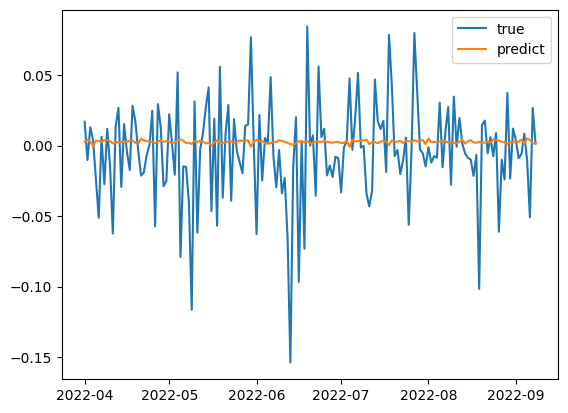

In [25]:
import matplotlib.pyplot as plt

plt.plot(test_data['date'], y_test, label='true')
plt.plot(test_data['date'], y_test_pred, label='predict')
plt.legend()

#### Variable Importance

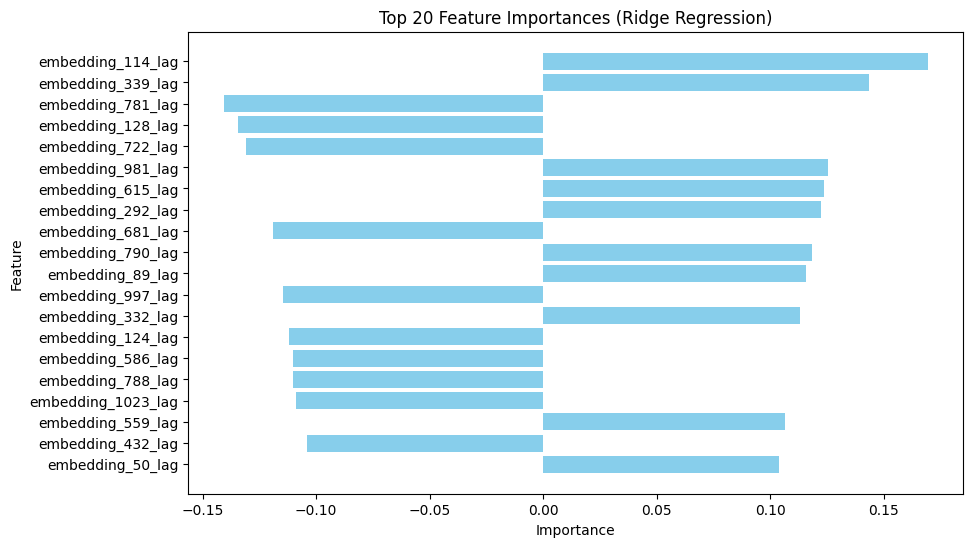

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature importance (coefficients) from the best ridge model
feature_importance = best_model.coef_

# Create a DataFrame for better visualization
feature_names = train_data.columns[2:]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by absolute importance
importance_df['Absolute Importance'] = np.abs(importance_df['Importance'])
importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False)

# Plot the top 20 most important features
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(top_n), importance_df['Importance'].head(top_n), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (Ridge Regression)')
plt.gca().invert_yaxis()
plt.show()